# <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center; border-radius: 15px 50px;"> Challenge 2 - ITI📚</p>

# Introduction 
This notebook uses the following dataset to predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.: https://www.kaggle.com/c/seoul-bike-rental-ai-pro-iti/overview. 

<br> This project consists of the following main sections:<br>
<ul>
    <li> I   : <a><b>Data Loading.</b></a></li>
    <ul>
        <li>1) loads the data from the csv files into data frame.
        <li>2) Concats the data (train and test) in one DataFrame.</li>
    </ul><br>
    <li> II  : <a><b>Exploratory data analysis.</b></a></li>
    <ul>
        <li>1) Gets feature dtypes, info, shape
        <li>3) plot feature distribution.
        <li>4) Exploring Missing data.
        <li>5) Analyzing target variable.
        <li>6) Correlation heatmap.</li>
    </ul><br>
    <li> III : <a><b>Data Pre_processing.</b></a></li>
    <ul>
        <li>1) Drop and Rename the needed columns   
        <li>2) convert date columns to datetime and to DMY 
        <li>3) Fills the null values with (mean, meadian, zero,....etc).
        <li>4) Encodes the data and Converts it to dummies values.
        <li>5) Normalizes the data before ML.</li>
    </ul><br>
    <li> IV  : <a><b>Machine Learning model preperation</b></a></li>
    <br>
    <li> V   : <a><b> Problem solution </b></a></li>
    <ul>
        <li>1) Load the files.
        <li>2) Show the information.
        <li>3) determine the preprocessing columns.
        <li>4) Applys the ML algorithms and shows the results.
        <li>5) Find the best model and then fits it to the data.
        <li>6) Save the predictions to a csv file.</li>
    </ul>
</ul>
<br>

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center; border-radius: 15px 50px;"> 1. Data Loading</p>


#### Loading Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#preprocessing and visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, QuantileTransformer, Normalizer

#model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score , max_error , mean_squared_log_error, make_scorer
from sklearn.compose import TransformedTargetRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-bike-rental-ai-pro-iti/sample_submission.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/train.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/test.csv


In [2]:
def load_data(file_path):
    file = pd.read_csv(file_path)
    return file

In [3]:
def all_data_concat(train, test):
    all_data = pd.concat(objs = [train, test], axis = 0)
    train_objs_num = len(train)
    return all_data, train_objs_num

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center; border-radius: 15px 50px;"> 2. Exploratory Data Analysis</p>


#### Data Information

In [4]:
def data_information(data, dataname):
    """ This function is to print all the details of dataset as the first part of the exploratory data analysis. """
    print(("-" * 100 ) + "\n" + dataname + ": DATA FRAME SHAPE:")
    print(data.shape) 
    print(("-" * 100 ) + "\n" + dataname +": DATA FRAME HEAD:")
    print(data.head(10))
    print(("-" * 100 ) + "\n" + dataname +": DATA FRAME COLUMNS:")
    print(data.columns)
    print(("-" * 100 ) + "\n" + dataname +": DATA FRAME DESCRIBTION:")
    print(data.describe())
    print(("-" * 100 ) + "\n" + dataname +": DATA FRAME INFO:")
    print(data.info())
    print(("-" * 100 ) + "\n" + dataname +": DATA FRAME NULLS:")
    print(data.isna().sum())  
    print(("-" * 100 ) + "\n")
    get_missing_values(data)
    print(("-" * 100 ) + "\n")
    numerical_features, categorical_features = data_type(data)
    print("Numerical features are :", numerical_features )
    print("Categorical features are :", categorical_features )
    print(("-" * 100 ) + "\n")


#### Seperate categorical data from numerical data

In [5]:
def data_type(data):
    """This function is used to seperate the categorical features and the numerical ones."""
    numerical_features = [x for x in data.select_dtypes(include='number').columns if x not in [target]]
    categorical_features = data.select_dtypes(exclude='number').columns.tolist()
    return numerical_features, categorical_features

#### Exploring Missing data

In [6]:
#Information about Missing Data
def get_missing_values(data, dataname = "data"):
    """ This function is used to get the missing data from the features and the ratios of each column. """
    print( "Number of missing values from " + dataname)
    #get the sum of all missing values in the dataset
    missing = data.isnull().sum()
    print("Missing data of each column")
    missing = missing[missing > 0]
    missing.sort_values(inplace = True)
    #missing.plot.bar()
    print("Missing data ratios from " + dataname)
    _nulls = (data.isnull().sum() / len(data)) * 100
    _nulls = _nulls[_nulls > 0]
    missing_data = pd.DataFrame({'Missing Ratio %' :_nulls}).sort_values('Missing Ratio %', ascending=False)
    print(missing_data)

#### Examining outlayers 

In [7]:
def examin_outlayers(data, columns):
    Q1 = data[columns].quantile(0.25)
    Q3 = data[columns].quantile(0.75)
    IQR = Q3 - Q1
    outliers_count = (((data[columns] < (Q1 - 1.5 * IQR)) | (data[columns] > (Q3 + 1.5 * IQR))).sum()).sort_values(ascending=False)
    print(outliers_count.head(12))
    

#### Numerical Features distribution 

In [8]:
def numerical_feature_distribution(data, numerical_features):
    """ This function is used to plot the numerical features' distripution """
    
    numerical_features_df = data[numerical_features].copy()
    skewed_feats = numerical_features_df.apply(lambda x: skew(x)).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skew_numerical = pd.DataFrame({'Skew' :skewed_feats})
    print(skew_numerical.head(10))
    
    data[numerical_features].hist(bins = 100, figsize=(30,25));


#### Features box plot

In [9]:
def ordina_features_boxplot(data,target):
    # creating orders list of pandas series that store the median values sorted of each category
    orders = []
    for col in ordinal:
        orders.append(data.groupby(by=[col])[target].median().sort_values())
    def boxplot(x, y, **kwargs):
        sns.boxplot(x=x, y=y)
        x=plt.xticks(rotation=90)

        #create a box plot to show how the output changes with qualitative features
    f = pd.melt(data, id_vars = target, value_vars = ordinal)
    g = sns.FacetGrid(f, col = "variable",  col_wrap = 4, sharex = False, sharey = False, height = 5)
    g = g.map(boxplot, "value", "y")

#### Plotting data ordered by mean of label

In [10]:
def label_col_plot(train,cols,label='y'):
    '''Plotting data ordered by mean of label in each category'''
    num_cols = int(len(cols))
    figure, axes = plt.subplots(int(np.ceil(num_cols/3)), 3)
    figure.suptitle('Plotting data ordered by mean of label in each category')
    
    
    figure.set_size_inches(15, 10)
    plt.tight_layout()
    rows = 0
    for i in range(0, num_cols-1, 3):
        mean_in_col = train[[cols[i],label]].groupby(cols[i]).mean()
        mean_in_col.sort_values(by=label,ascending=False)
        axes[rows, 0].scatter(x=mean_in_col.index,y=mean_in_col[label])
        title = cols[i] + " by mean of label in each category"
        axes[rows, 0].set_title(title)
        
        if (i+1) >= num_cols:
            break
        mean_in_col = train[[cols[i+1],label]].groupby(cols[i+1]).mean()
        mean_in_col.sort_values(by=label,ascending=False)
        axes[rows, 1].scatter(x=mean_in_col.index,y=mean_in_col[label])
        title = cols[i+1] + " by mean of label in each category"
        axes[rows, 1].set_title(title)
        
        if (i+2) >= num_cols:
            break
        mean_in_col = train[[cols[i+2],label]].groupby(cols[i+2]).mean()
        mean_in_col.sort_values(by=label,ascending=False)
        axes[rows, 2].scatter(x=mean_in_col.index,y=mean_in_col[label])
        title = cols[i+2] + " by mean of label in each category"
        axes[rows, 2].set_title(title)
        rows+=1
        

#### Categorical Features distribution 

In [11]:
def categorical_feature_distribution(data, categorical_features):
    """ This function is used to plot the categorical features features' distripution """
    for cat in categorical_features:
        f = plt.figure(figsize=(10,5))
        sns.countplot(x= cat, data = data)

#### Analyzing target variable

In [12]:
def analyze_target(data, target):
    sns.set(style = 'whitegrid', palette = "deep", font_scale = 1.1, rc = {"figure.figsize": [8, 5]})
    sns.histplot(data = data, x = target, bins = 100)
    
    target_df = data[:len(data)].copy()
    target_df = target_df[target]
    skewed_target = skew(target_df)
    print("\nSkew in target feature: \n")
    print(skewed_target)
    
    f,  (ax1, ax2)  =  plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

    ax1 = data[['Hour','y']].groupby(['Hour']).sum().reset_index().plot(kind='bar',
                                           legend = False, title ="Counts of Bike Rentals per hour", 
                                           stacked=True, fontsize=12, ax=ax1)
    ax1.set_xlabel("Hour", fontsize=12)
    ax1.set_ylabel("y", fontsize=12)

    ax2 = data[['Holiday','y']].groupby(['Holiday']).sum().reset_index().plot(kind='bar',  
          legend = False, stacked=True, title ="Counts of Bike Rentals by Day", fontsize=12, ax=ax2)

    ax2.set_xlabel("Holiday", fontsize=12)
    ax2.set_ylabel("Count", fontsize=12)
    ax2.set_xticklabels(['Holiday','No Holiday'])

    f.tight_layout()

#### Correlation heatmap

In [13]:
def heat_map_plot(data):
    """ This function is used to plot the Correlation heat map of all features. """
    f, ax = plt.subplots(figsize=(32, 26))
    corr = data.corr()
    mp = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, annot = True)
    mp.set_title(label='Dataset correlation', fontsize=20)

In [14]:
def plot_correlated_features(corr_features):
    """ This function is used to plot the highly correlated featurs and each other to find if we have to use polynomial 
        regression transformation  between them before using the linear regression at the end """    
    sns.pairplot(data[corr_features])

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center; border-radius: 15px 50px;"> 3. Data Preprocessing</p>

#### Drop unnecessary columns or rows

In [15]:
def drop_columns(data, cols_drop):
    """This function is used to drop a column or row from the dataset."""
    drop_strategies = [(cols_drop,1)]
    for columns, ax in drop_strategies:
        if len(columns) == 1: 
            data = data.drop(labels = columns, axis = ax)
        else:
            for column in columns:
                data = data.drop(labels = column, axis = ax)
    return data

#### Rename necessary columns

In [16]:
def rename_columns(data, cols_rename):
    """This function is to rename columns. """
    data = data.rename(columns = cols_rename)
    return data

#### Map categorical columns to numerical 

In [17]:
def map_cat_to_num(data, col, values):
    """This function is to transform categorical value from column to numerical value >> { : , :}. """
    data[col]= data[col].map(values)
    return data

#### Convert object (String) columns to categorical columns


In [18]:
def string_to_categorical(data, cols):
    for col in cols:
        data[col] = pd.Categorical(data[col])
    return data

#### Impute raw values with other values 

In [19]:
def impute_row_values(data, col, val0, val1):     
    """This function is to replace value 0 from column with value1. """
    data[col] = data[col].transform(lambda x:val1 if(x==val0) else x)
    return data

#### Extract Date column into year, month and day columns 

In [20]:
def extract_DMY_form_date(data, date_col):
    data[date_col] = pd.to_datetime(data[date_col])
    data["Day"] = data[date_col].dt.dayofweek
    data["Month"] = data[date_col].dt.month
    data["Year"] = data[date_col].dt.year    
    return data

#### Fill NA/NAN values with zero,mean,mode,...

In [21]:
#This part is taken from the notebook found here : https://www.kaggle.com/alaasedeeq/object-oriented-programming-for-data-science
def fillna(data, fill_strategies):       
    """This function fills NA/NaN values in a specific column using a specified method(zero,mean,...)"""
    def fill(column, fill_with):
            if str(fill_with).lower() in ['zero', 0]:
                data[column].fillna(0, inplace=True)
            elif str(fill_with).lower()=='mode':
                data[column].fillna(data[column].mode()[0], inplace=True)
            elif str(fill_with).lower()=='mean':
                data[column].fillna(data[column].mean(), inplace=True)
            elif str(fill_with).lower()=='median':
                data[column].fillna(data[column].median(), inplace=True)
            else:
                data[column].fillna(fill_with, inplace=True)
            return data    
    #imputing columns according to its strategy
    for columns, strategy in fill_strategies:
        if len(columns)==1:
            fill(columns[0], strategy)
        else:
            for column in columns:
                fill(column, strategy)
    return data

#### Group columns

In [22]:
# put here the columns you needed to be grouped together
def grouping_columns(cols_group):
    """ This function is used to group any needed columns togeether. """
    pass

#### Encode data to categorical values

In [23]:
def label_encoder(data,columns):
    """ This function is used to encode the data to categorical values """
    # Convert all categorical collumns to numeric values
    lbl = LabelEncoder() 
    data[columns] = data[columns].apply(lambda x:lbl.fit_transform(x.astype(str)).astype(int))
    return data 

#### Convert data to dummies values

In [24]:
def get_dummies(data,columns):
    """This function is used to convert the data to dummies values. """
    # convert our categorical columns to dummies
    for col in columns:
        dumm = pd.get_dummies(data[col], prefix = col, dtype = int)
        data = pd.concat([data, dumm], axis = 1)
    data.drop(columns, axis = 1, inplace = True)
    return data

#### Normalize the data

In [25]:
def norm_data(data,columns):
    """ This function is used to normalize numeric the data."""
    data[columns] = data[columns].apply(lambda x:np.log1p(x)) #Normalize the data with Logarithms
    return data

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center; border-radius: 15px 50px;">5. ML Model Preperation</p>

### Input Output distributions

In [26]:
def plot_dist(y, y_pred_test, y_pred_train, y_pred_val):
    figure, axes = plt.subplots(ncols=4)
    figure.set_size_inches(20, 4)
    plt.tight_layout()
    sns.histplot(y, ax=axes[0], bins=100, kde = True)
    axes[0].set_title('Original Data (Train+Val) Distribution')
    sns.histplot(y_pred_test, ax=axes[1], bins=100,  kde = True)
    axes[1].set_title('Predicted Test Data Distribution')
    sns.histplot(y_pred_train, ax=axes[2], bins=100, kde = True)
    axes[2].set_title('Predicted Train Data Distribution')
    if y_pred_val != None:
        sns.histplot(y_pred_val, ax=axes[3], bins=100, kde = True)
        axes[3].set_title('Predicted Val Data Distribution')

### Root Mean Square Log Error

In [27]:
def rmsle(y_true, y_pred, convertExp=True):
    # Apply exponential transformation function
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # Convert missing value to zero after log transformation
    log_true = np.nan_to_num(np.array([np.log(y+1) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1) for y in y_pred]))
    
    # Compute RMSLE
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output



### Feature Importances


In [28]:
def plot_feature_importances(model):
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(X.columns, model.feature_importances_):
        feats[feature] = importance #add the name/value pair 

    plt.figure(figsize=(30,7))
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
    importances.sort_values(by='importance').plot(kind='bar', rot=90)

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center; border-radius: 15px 50px;">5. Problem Solution</p>

<h2><center>Load train and test datasets</center></h2>

In [29]:
#load datasets into two datfarmes : train and test 
train_data = load_data("../input/seoul-bike-rental-ai-pro-iti/train.csv")
test_data = load_data("../input/seoul-bike-rental-ai-pro-iti/test.csv")


#concatenate all train and test data into one dataset
all_data, train_objs_num = all_data_concat(train_data, test_data)


#Select the target column
target = "y"
seed = 2021

<h2><center>Display Information about the Data</center></h2>

In [30]:
###Display general initial information about the dataset
# shape  # info  # description  # nulls  # oultliers
data_information(all_data, " All Dataset")

----------------------------------------------------------------------------------------------------
 All Dataset: DATA FRAME SHAPE:
(8760, 15)
----------------------------------------------------------------------------------------------------
 All Dataset: DATA FRAME HEAD:
   ID        Date      y  Hour  Temperature(�C)  Humidity(%)  \
0   0  01/12/2017  254.0     0             -5.2           37   
1   1  01/12/2017  204.0     1             -5.5           38   
2   2  01/12/2017  173.0     2             -6.0           39   
3   3  01/12/2017  107.0     3             -6.2           40   
4   4  01/12/2017   78.0     4             -6.0           36   
5   5  01/12/2017  100.0     5             -6.4           37   
6   6  01/12/2017  181.0     6             -6.6           35   
7   7  01/12/2017  460.0     7             -7.4           38   
8   8  01/12/2017  930.0     8             -7.6           37   
9   9  01/12/2017  490.0     9             -6.5           27   

   Wind speed (m/s)

 <h2><center>Feature Preprocessing</center></h2>

In [31]:
# def preprocessing(data, data_name = "Dataset"):
#     cols_rename = {"Temperature(�C)": "Temperature", "Dew point temperature(�C)": "Dew point temperature"}
#     data = rename_columns(data, cols_rename)                                      # Rename columns
#     data = extract_DMY_form_date(data, "Date")                                    # Change date into Day, month and year columns
#     data = map_cat_to_num(data,"Holiday",{"No Holiday":0,'Holiday':1})            # Map values of specific columns
#     data = map_cat_to_num(data, "Functioning Day" , {"No":0,'Yes':1})
#     data["Weekend"]=[1 if x>=5 else 0 for x in data["Day"]]
#     data["isHoliday"] = data['Weekend']| data["Holiday"]
    
#     #data = drop_columns(data, [""])                                              # Drop columns
#     #data = get_dummies(data,['Day','Year',"Seasons",'Functioning Day',"isHoliday","Holiday","Weekend"]) 
#     #data = map_cat_to_num(data, "Seasons" , {'Spring': 1, 'Summer': 2,'Autumn':3,'Winter':4})
#     #data = impute_row_values(data, cat_column_to_change, val0, val1)              # Impute row value
#     #data = impute_row_values(data, "Solar Radiation (MJ/m2)", 0, data["Solar Radiation (MJ/m2)"].mean)
#     #data = norm_data(data,norm_columns)                                           # Normalize columns
#     #label_encoder(data,["Seasons", "Hour", "Day", "Month","Year","Holiday","Functioning Day"])
    
#     print("Data preprocessing of " + data_name + " ended sucssesfully")
#     return data

In [32]:
def preprocessing(data, data_name = "Dataset"):
    all_data_processed["Date"] = pd.to_datetime(all_data_processed["Date"],format='%d/%m/%Y')
    all_data_processed["Holiday"]= all_data['Holiday'].map( {"No Holiday": 0,'Holiday': 1})
    all_data_processed["Functioning Day"]= all_data["Functioning Day"].map( {"No": 0,'Yes': 1})
    all_data_processed["Month"] = all_data_processed['Date'].dt.month
    all_data_processed["Year"] = all_data_processed['Date'].dt.year
    all_data_processed["Day"] = all_data_processed['Date'].dt.dayofweek
    all_data_processed["Weekend"]=[1 if x>=5 else 0 for x in all_data_processed["Day"]]
    all_data_processed["isHoliday"] = all_data_processed['Weekend']| all_data_processed["Holiday"]
    
    print("Data preprocessing of " + data_name + " ended sucssesfully")
    return all_data_processed

In [33]:
all_data = all_data.rename(columns={"Temperature(�C)": "Temperature", "Dew point temperature(�C)": "Dew point temperature"})
all_data_processed = all_data.copy()
all_data_processed = preprocessing(all_data_processed, "All dataset")
train_processed = all_data_processed[:train_objs_num]
test_processed = all_data_processed[train_objs_num:]

Data preprocessing of All dataset ended sucssesfully


In [34]:
numerical = ['Temperature', 'Humidity(%)','Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature',
             'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
ordinal = ['Year','Month','Day','Hour', 'Seasons', 'Holiday', 'Functioning Day', 'isHoliday']
target = 'y'
numerical_and_target = numerical + list(target)
all_features = numerical_and_target + ordinal

<h3><center>Target Feature Historgram</center></h3>


Skew in target feature: 

1.1587583316633234


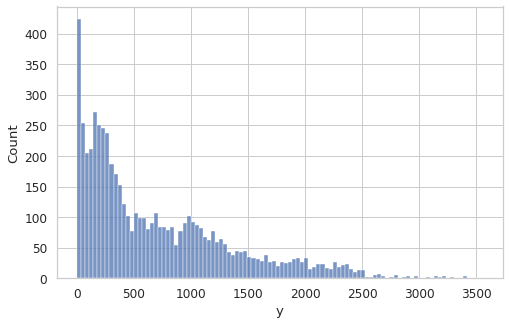

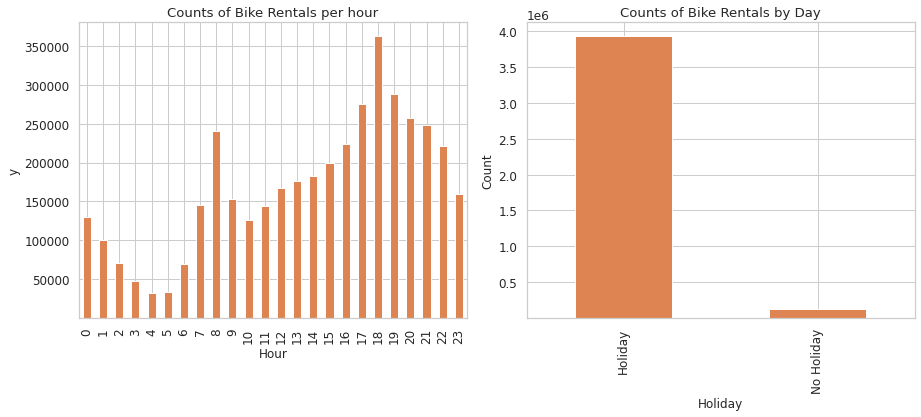

In [35]:
analyze_target(train_processed, target)

<h3><center>Numerical Features Distribution</center></h3>


Skew in numerical features: 

                              Skew
Rainfall(mm)             15.632379
Snowfall (cm)             8.906190
Solar Radiation (MJ/m2)   1.485213
Wind speed (m/s)          0.936237
Humidity(%)               0.110608
Temperature              -0.171514
Dew point temperature    -0.320783
Visibility (10m)         -0.807016


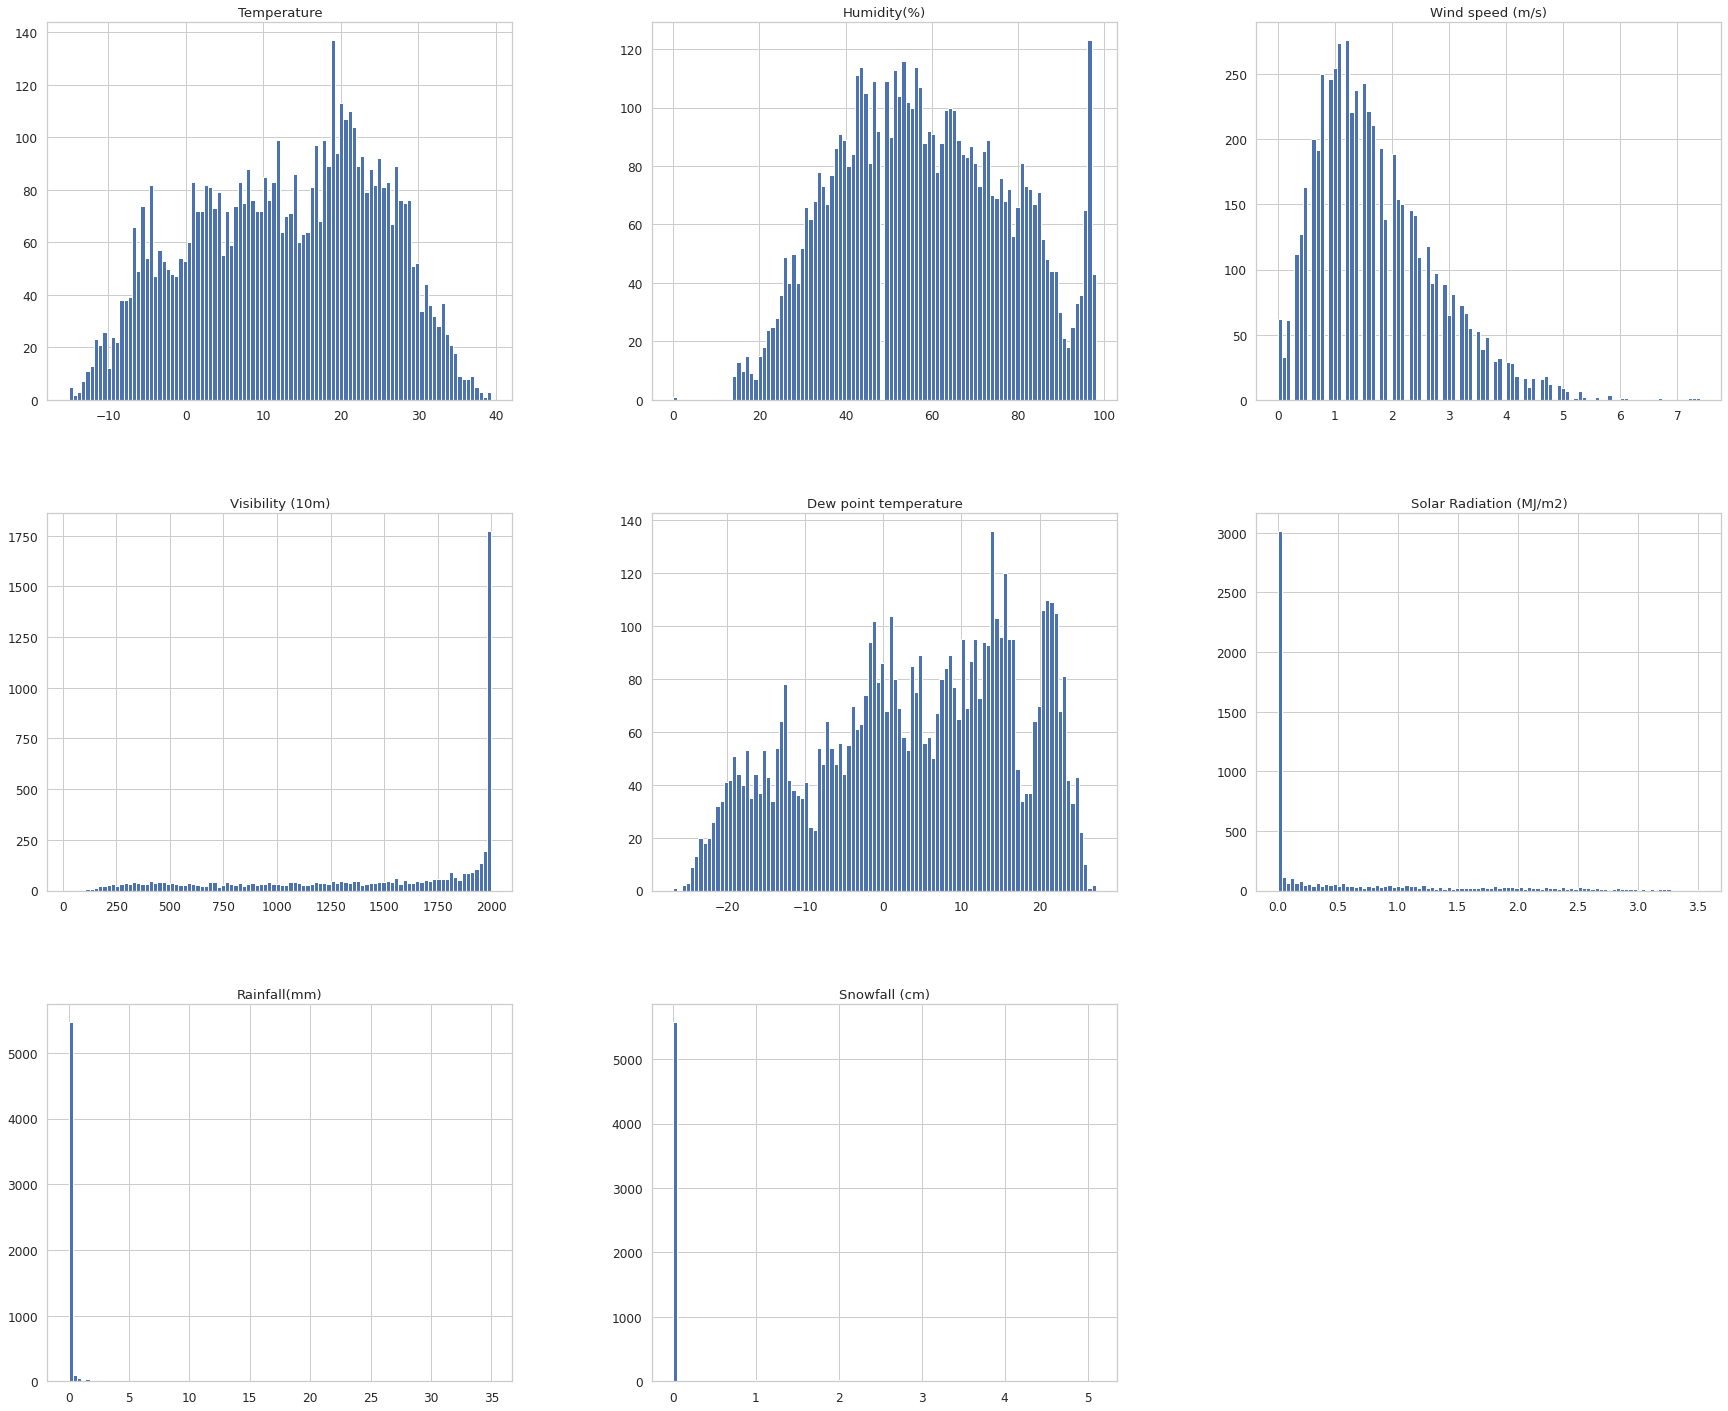

In [36]:
numerical_feature_distribution(train_processed, numerical)

<h3><center>Ordinal features box plot</center></h3>

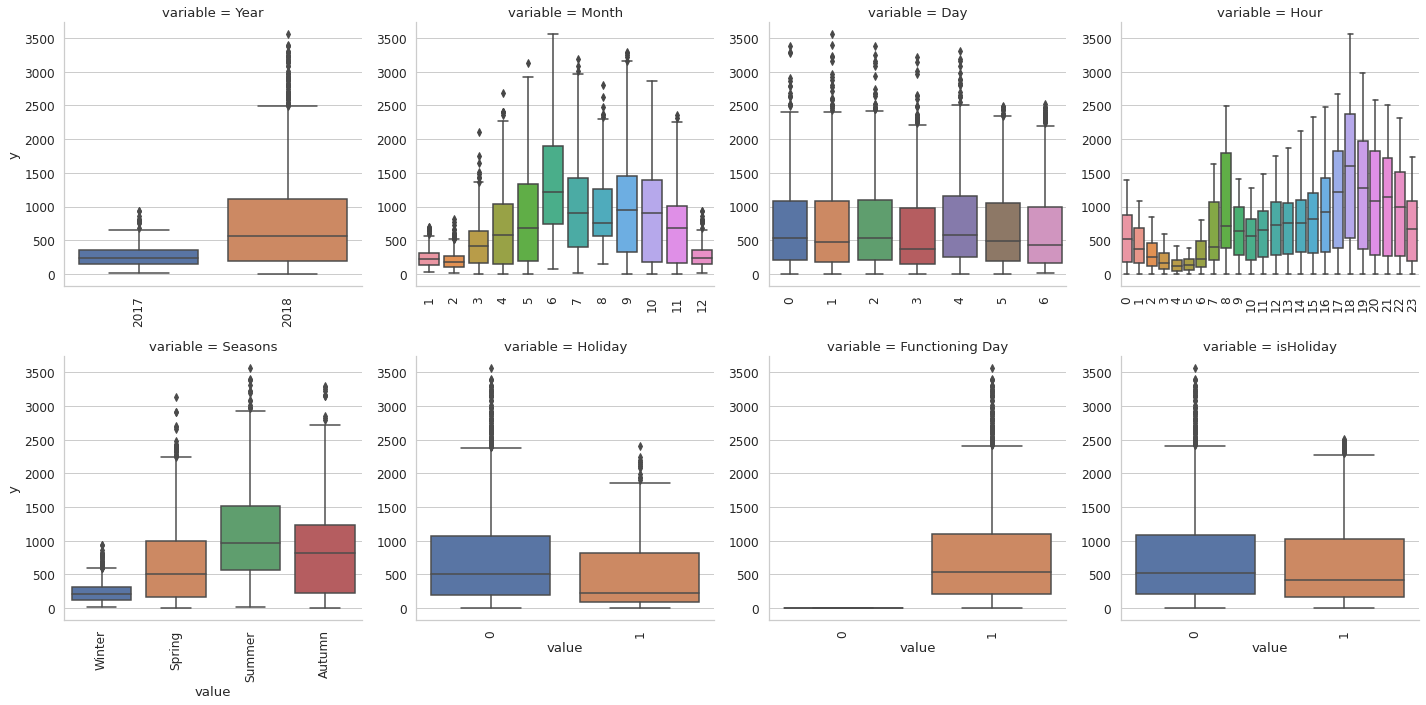

In [37]:
ordina_features_boxplot(train_processed, target)

## Notes:
* Year: Data in 2018 is much larger than data in 2017
* Hour: There is a trend in hour, greatest demand is at 6 pm
* Seasons: Number of bike rental counts is greater in summer. It's order is Winter, Spring, Autmn, Summer. This is reflected also by month
* Holiday: holidays without weekends, and isHoliday: holidays with weekends. Days with no holiday has a slightly higher median than days with holidays

<h3><center>Label column plot</center></h3>

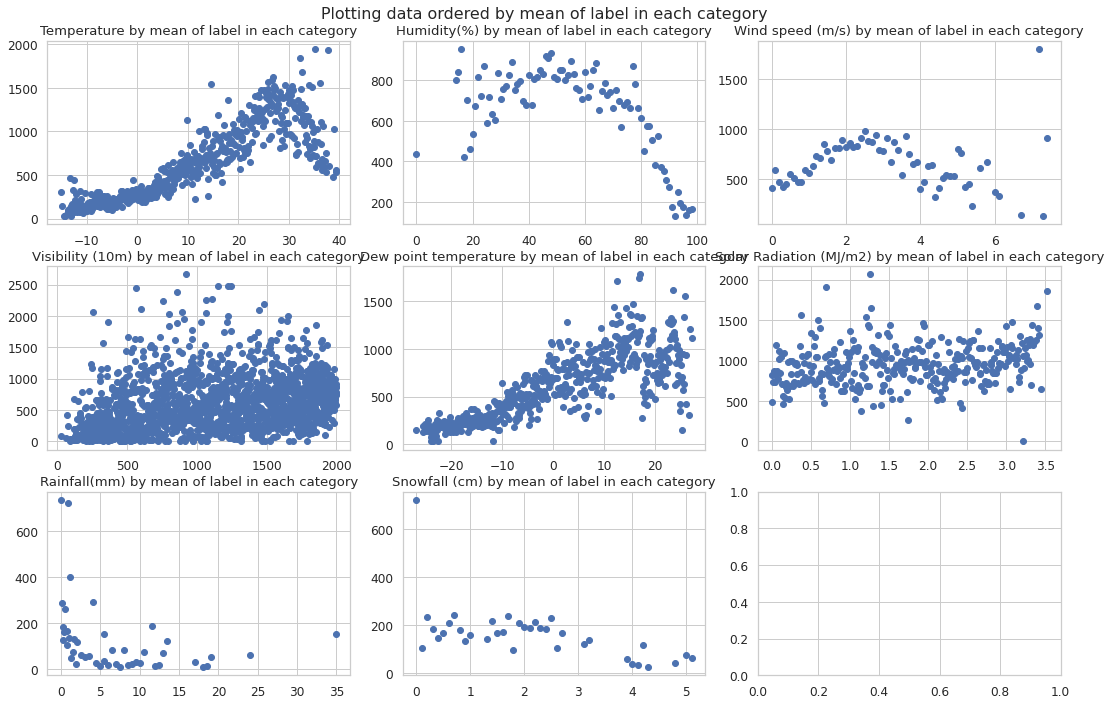

In [38]:
label_col_plot(train_processed,numerical)

## Notes:
* Year: Data in 2018 is much larger than data in 2017
* Hour: There is a trend in hour, greatest demand is at 6 pm
* Seasons: Number of bike rental counts is greater in summer. It's order is Winter, Spring, Autmn, Summer. This is reflected also by month
* Holiday: holidays without weekends, and isHoliday: holidays with weekends. Days with no holiday has a slightly higher median than days with holidays

<h3><center>Detecting relationships</center></h3>

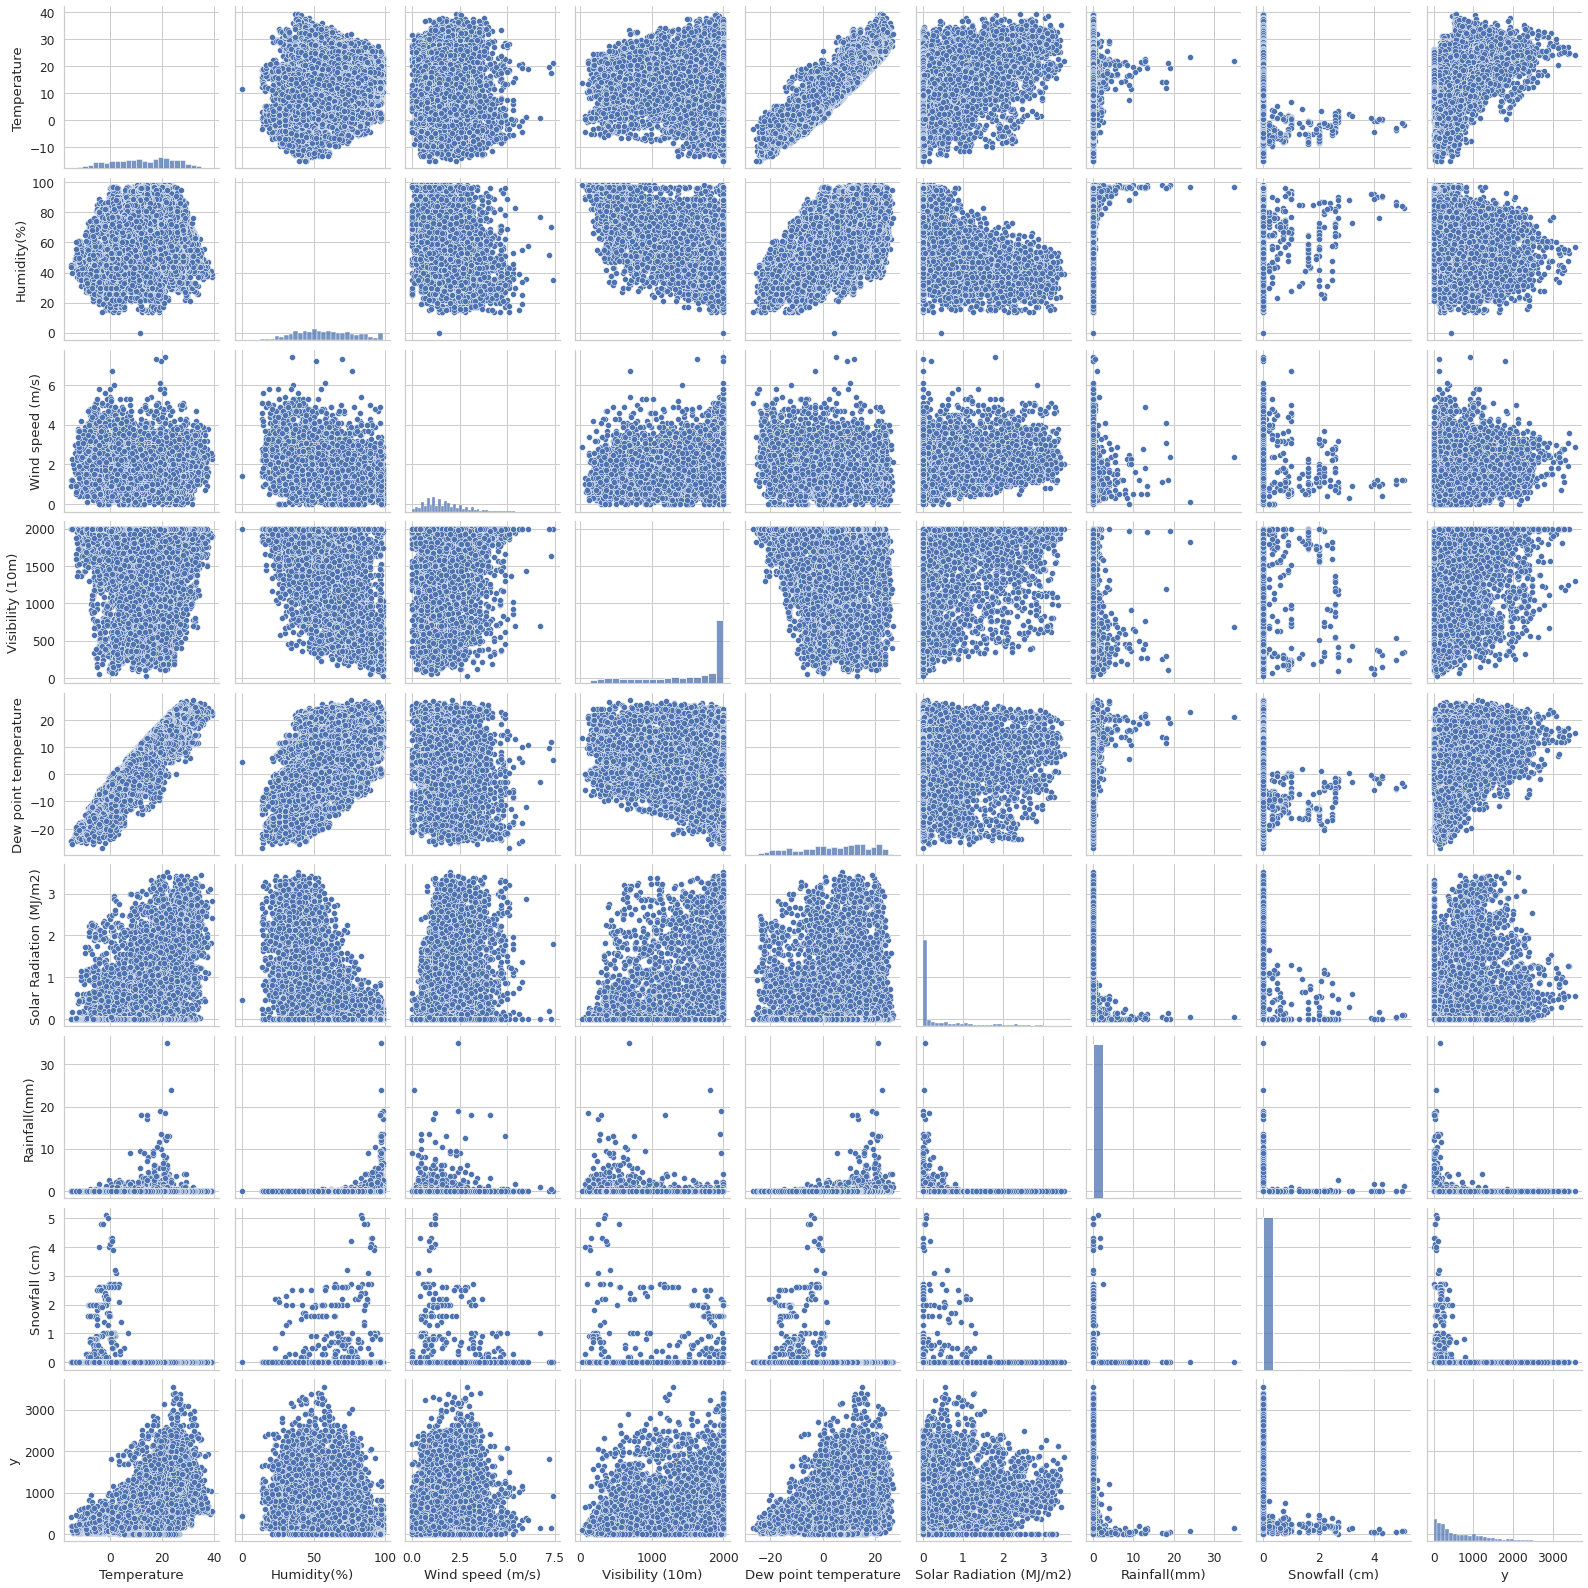

In [39]:
sns.pairplot(train_processed[numerical_and_target])

## Notes:
* There is no linear relationships except tempreture with dew tempreture and dew tempreture with humidity. 
* Linear regression will most likely not work

<h3><center>Visualize correlation</center></h3>

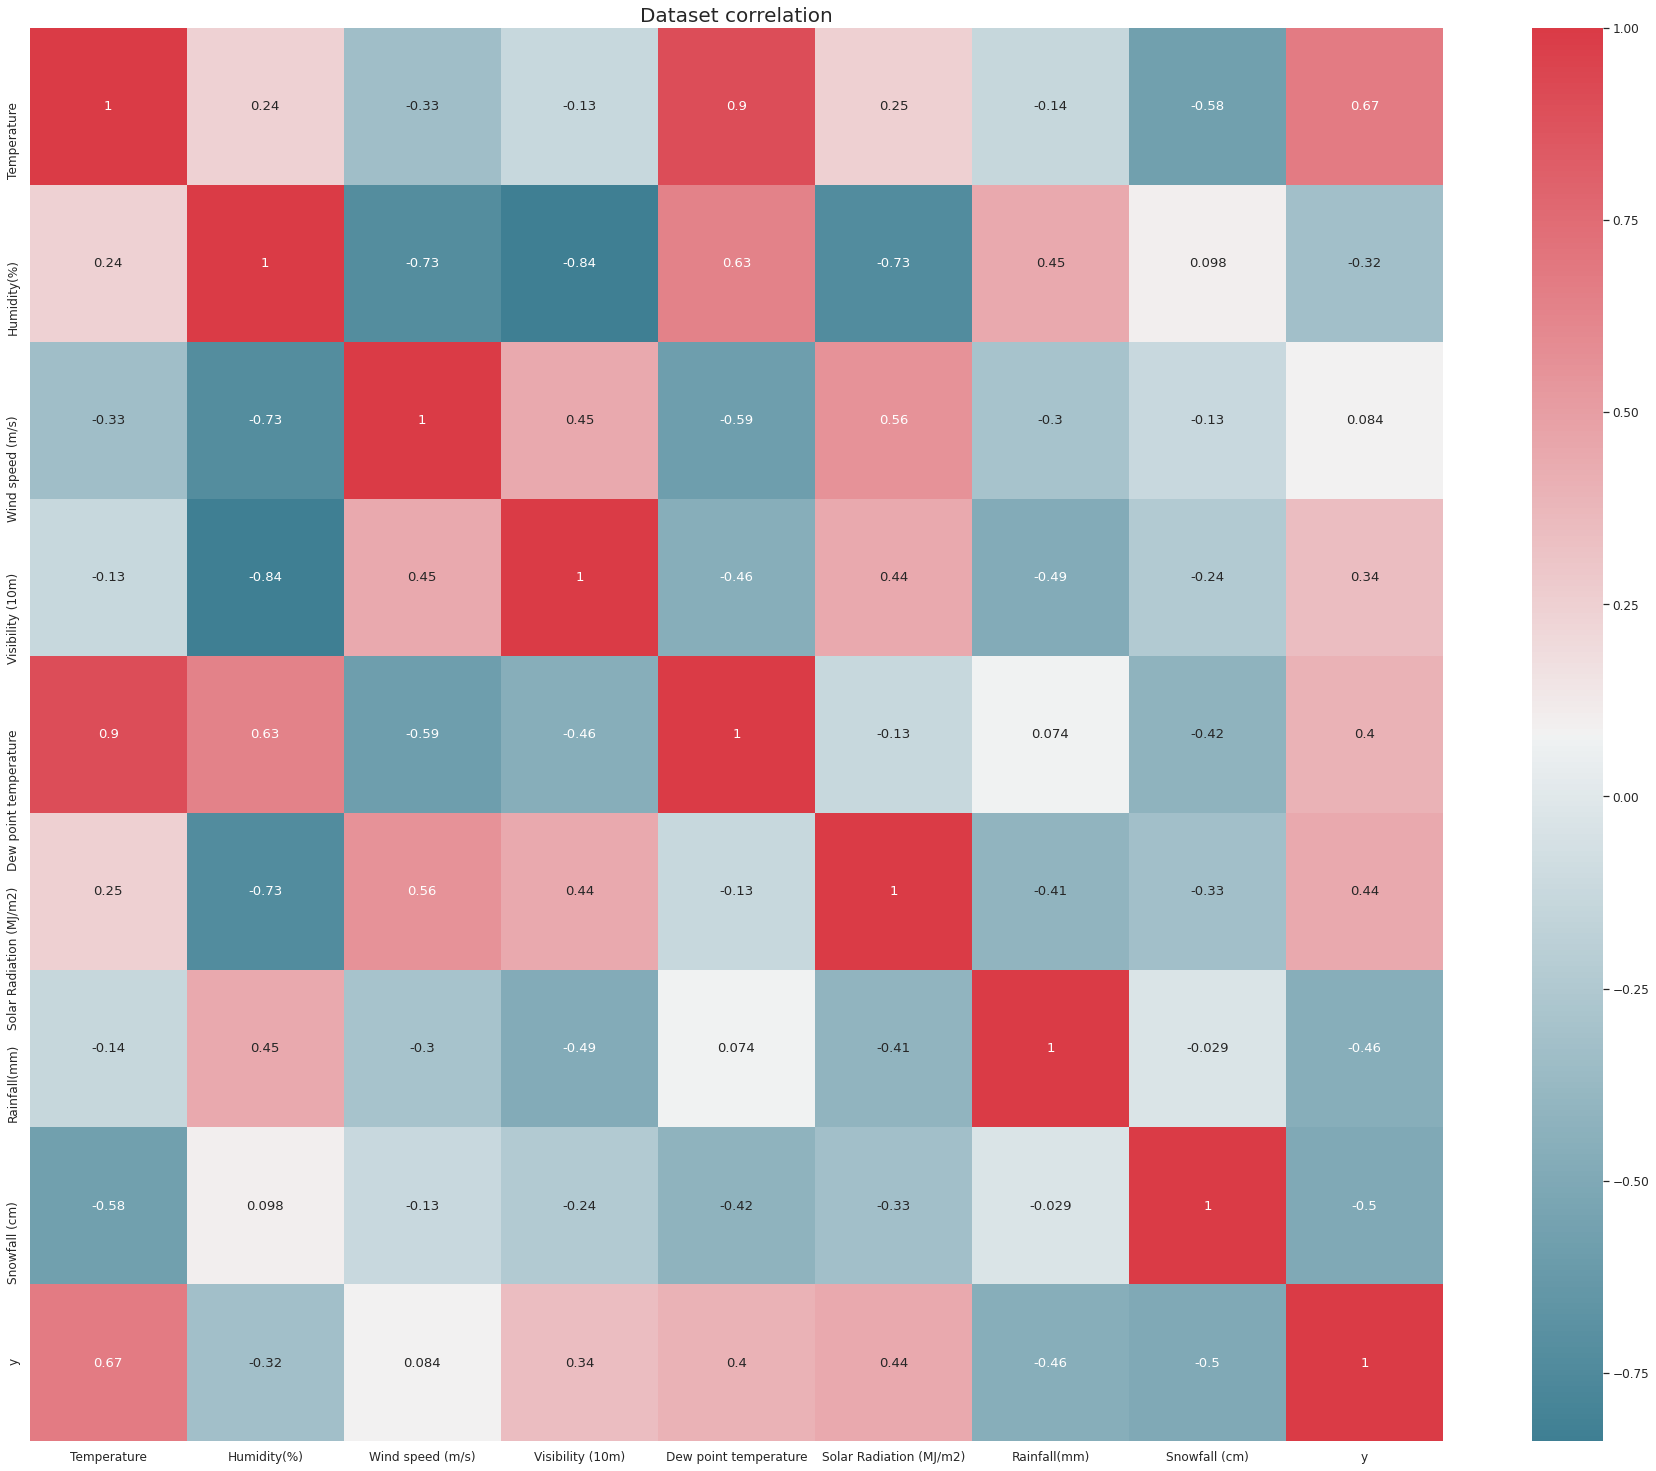

In [40]:
corr = train_processed[numerical_and_target].corr()
heat_map_plot(corr)

<h3><center>Examining Outliers</center></h3>

In [41]:
examin_outlayers(train_processed,all_features)

Year                       480
Solar Radiation (MJ/m2)    407
Rainfall(mm)               332
Functioning Day            247
Holiday                    240
Snowfall (cm)              180
Wind speed (m/s)           122
y                          109
Temperature                  0
isHoliday                    0
Visibility (10m)             0
Day                          0
dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  """


<h3><center>Time Series Plot </center></h3>

<AxesSubplot:xlabel='Date', ylabel='y'>

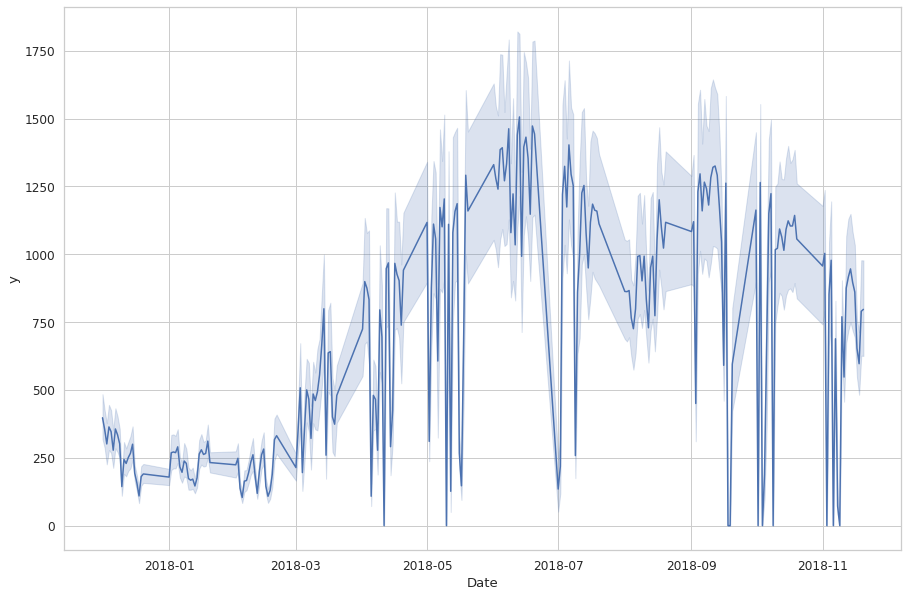

In [42]:
plt.figure(figsize=(15,10))
sns.lineplot(x="Date", y="y",
             data=train_processed)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='Year_month', ylabel='y'>

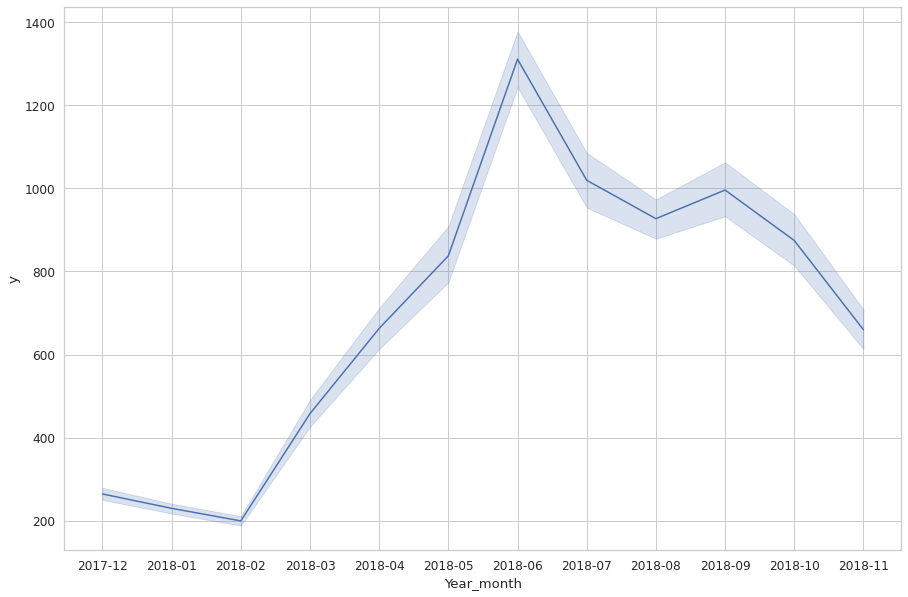

In [43]:
train_processed["Year_month"] = train_processed["Date"].dt.strftime('%Y-%m')
plt.figure(figsize=(15,10))
sns.lineplot(x="Year_month", y="y",
             data=train_processed)


<h3><center>Feature Engineering </center></h3>

In [44]:
all_data_processed = pd.get_dummies(all_data_processed, columns=['Day','Year',"Seasons",'Functioning Day',"isHoliday","Holiday","Weekend"])

In [45]:
train = all_data_processed[:train_objs_num]
test = all_data_processed[train_objs_num:]

<h1><center>ML Model</center></h1>

 <h3><center>Feature Selection </center></h3>

In [46]:
selected_features = ['Hour', 'Temperature', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)' ,'Solar Radiation (MJ/m2)','Rainfall(mm)', 'Month', 'Day_0',
       'Day_5', 'Day_6',  'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer',
       'Seasons_Winter', 'Functioning Day_0', 'Functioning Day_1',
       'Holiday_0', 'Holiday_1','Weekend_0', 'Weekend_1']


X = train[selected_features]
y_no_log = train[target]
y = np.log1p(y_no_log)
X_test = test[selected_features]


 <h3><center>Train Test Split </center></h3>

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.4, random_state=seed, shuffle = True)

<h3><center>Apply the ML Model (Gradient Boosting) </center></h3>


* Try grid search for gradient boosting parameters (All Data)

In [48]:
# gbr = GradientBoostingRegressor(random_state=seed)
# parameters = {'learning_rate': [0.01, 0.02, 0.03, 0.1],
#                 'subsample'    : [0.3, 0.5, 1],
#                 'n_estimators' : [1000, 2000, 3000],
#                 'max_depth'    : [4, 5, 6, 7],
#                 'loss'         : ["huber","ls"],
#                 'min_samples_leaf': [1,2,3,4], 
#                 'max_leaf_nodes': [None, 10, 20],
#                 'max_features': ["log2", "sqrt", None]
#                 }
# rmsle_scorer = make_scorer(rmsle, greater_is_better=False) 
# grid_search_gradient_boosting = GridSearchCV(gbr, parameters, cv = 5, 
#                                             n_jobs=-1, scoring=rmsle_scorer, verbose=True)


# pipeline = make_pipeline(StandardScaler(), grid_search_gradient_boosting)
# #pipeline.fit(X, y)

* Train the best estimator on the training data


In [49]:
# grid_search_gradient_boosting.best_estimator_

In [50]:
gbr = GradientBoostingRegressor(learning_rate=0.02, max_depth=10, max_features=21,
                                n_estimators=5000, subsample=0.6, loss='huber', min_samples_leaf=2,
                               max_leaf_nodes=4, random_state=2)

pipeline = make_pipeline(StandardScaler(), gbr)
pipeline.fit(X_train, y_train)

y_train_predicted = pipeline.predict(X_train) 
y_train_predicted = np.expm1(y_train_predicted)
y_train_predicted[y_train_predicted<0] = 0

y_val_predicted = pipeline.predict(X_val) 
y_val_predicted = np.expm1(y_val_predicted)
y_val_predicted[y_val_predicted<0] = 0

print("The square root of the mean square log error of the training data is",
       mean_squared_log_error(np.expm1(y_train), y_train_predicted)**0.5)
print("The square root of the mean square log error of the validation data is",
       mean_squared_log_error(np.expm1(y_val), y_val_predicted)**0.5)


# The square root of the mean square log error of the training data is 0.26309761317444164
# The square root of the mean square log error of the validation data is 0.3523324928122321

The square root of the mean square log error of the training data is 0.26712404464686557
The square root of the mean square log error of the validation data is 0.35780450757297383


* All data training and submission

In [51]:
pipeline.fit(X, y)

y_train_predicted = pipeline.predict(X) 
y_train_predicted = np.expm1(y_train_predicted)
y_train_predicted[y_train_predicted<0] = 0

print("The square root of the mean square log error of all data is", 
      mean_squared_log_error(np.expm1(y), y_train_predicted)**0.5)

## 0.27693606780155

The square root of the mean square log error of all data is 0.28153816564071926


In [52]:
y_test_predicted = pipeline.predict(X_test) 
y_test_predicted = np.expm1(y_test_predicted)

* Making non- functioning day counts to 0

In [53]:
y_functioning_0_indx = np.where(X_test["Functioning Day_1"] == 0)[0]
y_test_predicted[y_functioning_0_indx] = 0

* Output Analysis

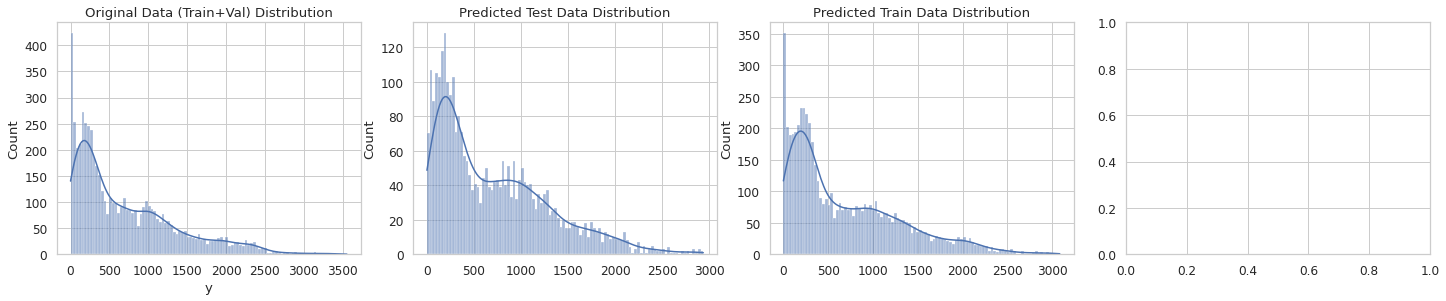

In [54]:
plot_dist(np.expm1(y), y_test_predicted, y_train_predicted, None)

<Figure size 2160x504 with 0 Axes>

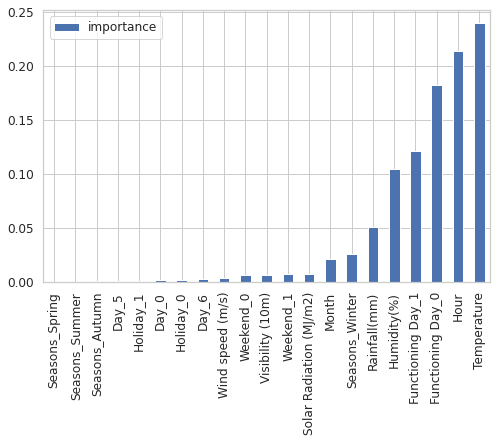

In [55]:
plot_feature_importances(gbr)

 <h3><center>Submission </center></h3>


In [56]:
test_data['y']= np.round(y_test_predicted)
output = test_data[['ID','y']]
output.to_csv("/kaggle/working/submission.csv", index=False)